# Import

In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import torch
from torch import nn, optim
from torch import autograd
import torch.nn.functional as F
from torch.nn import Parameter
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset,DataLoader,Subset
from PIL import Image,ImageOps,ImageEnhance

import cv2
import albumentations as A
from albumentations.pytorch import ToTensor

import glob
import xml.etree.ElementTree as ET #for parsing XML
import shutil
from tqdm import tqdm
import time
import random
import os
from tqdm import tqdm_notebook
import imageio


from albumentations import (
    BboxParams,
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    PadIfNeeded,
    Compose
)

In [4]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

## Variables

In [44]:
ORIGIN_IMAGES_PATH = 'data/motobike'
OUTPUT_IMAGES_PATH = 'data/resized128_image_fixed'

# Data loader

In [45]:
data_list = os.listdir(ORIGIN_IMAGES_PATH)
data_path = ORIGIN_IMAGES_PATH

In [46]:
len(data_list)

10374

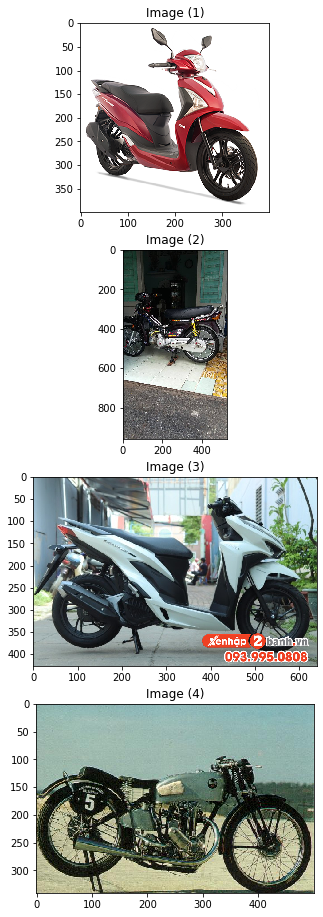

In [47]:
np.random.shuffle(data_list)
sample_images = [plt.imread(os.path.join(data_path, data_list[i])) for i in range(4)]
show_images(sample_images, cols=4)

In [48]:
fname = data_list[random.randint(0, len(data_list))]

In [80]:
def crop_image(data_path, fname):
    path = os.path.join(data_path, fname)
    name = '.'.join(fname.split('.')[:-1])
    if path.split('.')[-1] == 'gif':
        gif = imageio.mimread(path)
        nums = len(gif)
        print("Total {} frames in the gif!".format(nums))
        imgs = [cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in gif]
        image = imgs[0]
    else:
        image = cv2.imread(path, cv2.IMREAD_COLOR)
    image_size = image.shape[:2]

    preprocess = Compose([
#         PadIfNeeded(min_width=256, min_height=256),
    #     CenterCrop(width=min(image_size), height=min(image_size)),
        Resize(128, 128, interpolation=cv2.INTER_AREA),
#         CenterCrop(width=128, height=128, p=1.0)
    ])
    image = preprocess(image=image)['image']
    return image, f'{name}.png'

In [83]:
np.random.shuffle(data_list)
input_list = data_list[:10]
print(input_list)
c = ['Motorkrffqw99smallMotor.jpg']

result_image = []

for fname in input_list:
    try:
        image, _ = crop_image(data_path, fname)
        result_image.append(image)
    except:
        pass

['39_xe_may_dien_detech_espero_xmen_h883_1568719159012_8330.jpg', 'Motor_rer_qjlsmallMotor.jpg', '44_997_vario_150_1568719064955_7010.jpg', '0569_1568719768353_16798.jpg', '0124_1568719737558_16370.jpg', '0437_1568719759632_16680.jpg', '56_6344_huong_decal_dich_vu_trang_tri_xe_may_tem_do_air_blade_thai_son_phoi_mau_xanh_la_1568719136556_8004.jpg', 'Motor8ldriijqsmallMotor.jpg', '37_bbt_ducati_1_720x540_1568719031747_6535.jpg', '69_two1388389322_1568719140439_8060.jpg']


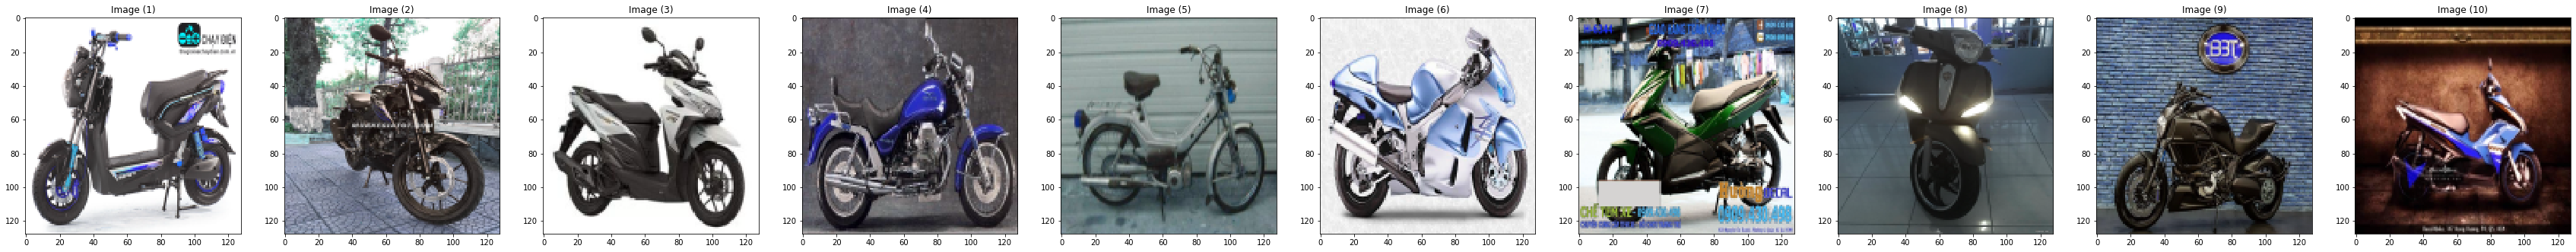

In [84]:
show_images(result_image, cols=1)

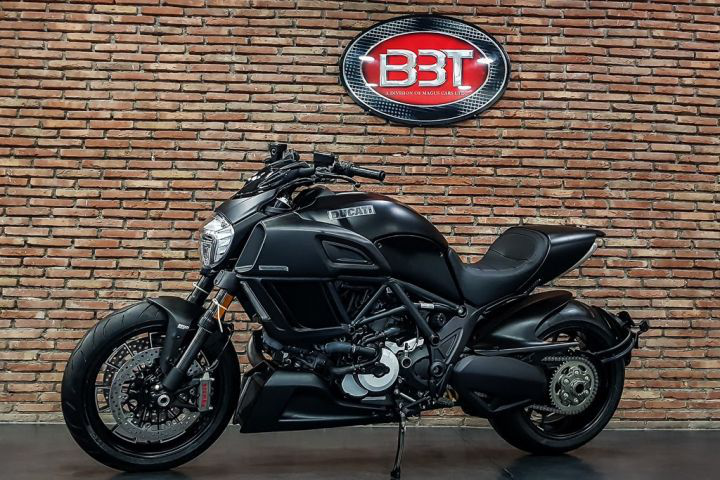

In [85]:
Image.open(f'data/motobike/{input_list[8]}')

In [86]:
!rm -rf {OUTPUT_IMAGES_PATH}
!mkdir {OUTPUT_IMAGES_PATH}

In [87]:
out_dir = OUTPUT_IMAGES_PATH

In [91]:
for fname in tqdm_notebook(data_list):
    try:
        image, new_name  = crop_image(data_path, fname)
        out_path = os.path.join(out_dir, new_name)
        cv2.imwrite(out_path, image)
    except :
        print("Keep ", fname)
        pass

Total 1 frames in the gif!
Total 6 frames in the gif!
Keep  .ipynb_checkpoints
Total 1 frames in the gif!
Total 1 frames in the gif!
Total 1 frames in the gif!
Total 1 frames in the gif!
Total 1 frames in the gif!
Keep  Motorheiow5b5smallMotor.jpg
Total 1 frames in the gif!



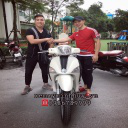

In [70]:
Image.open(os.path.join(out_dir, 'Motorkrffqw99smallMotor.jpg'))

# Define dataset

In [16]:
# generate 64x64 images!
#resize_size = 84
img_size    = 64
NUM_WORKERS = 1
batch_size  = 32

mean = 0.5, 0.5, 0.5
std = 0.5, 0.5, 0.5

transform1 = transforms.Compose([transforms.Resize(img_size)])
#transform1 = transforms.Compose([transforms.Resize((resize_size,resize_size))])

transform2 = transforms.Compose([transforms.RandomCrop(img_size),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=mean, std=std),
                                ])

In [21]:
class MotorbikeDataset(Dataset):
    def __init__(self, path, img_list, transform1=None, transform2=None):
        self.path      = path
        self.img_list  = img_list
        self.transform1 = transform1
        self.transform2 = transform2
        self.load_data(img_list)

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,idx):
        img = self.images[idx]
        if self.transform2:
            img = self.transform2(img)
        return img
    
    def load_data(self, img_list):
        self.images = []
        for idx, path in enumerate(img_list):
            img = Image.open(os.path.join(self.path, self.img_list[idx]))
            img = self.transform1(img)
            self.images.append(img)
        return self.images

In [23]:
img_list = os.listdir(OUTPUT_IMAGES_PATH)
dataset = MotorbikeDataset(OUTPUT_IMAGES_PATH, img_list, transform1, transform2)

In [24]:
%%timeit
dataset[0]

224 µs ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
train_loader = DataLoader(dataset,
                          shuffle=True, 
                          batch_size=batch_size,
                          num_workers=NUM_WORKERS, pin_memory=True)

In [26]:
import shutil
output_filename = 'preprocess'
dir_name = 'data/resized128_image'
shutil.make_archive(output_filename, 'zip', dir_name)

'/Users/admin/ZaloAi/motorbike-generator/preprocess.zip'

In [5]:
from evaluation import evaluation
import os
import sys
from client.mifid_demo import MIFID
from glob import glob
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm_notebook
import shutil

In [2]:
evaluation('data/resized128_image_new')

/Users/admin/anaconda3/envs/ml36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/admin/anaconda3/envs/ml36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/admin/anaconda3/envs/ml36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/admin/anaconda3/envs/ml36/lib/python3.6/site-

[Motorbike Classifer] Load Motorbike Classifer from ./client/motorbike_classification_inception_net_128_v4_e36.pb
Load Public Embedding Features


error: OpenCV(4.1.1) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [14]:
def evaluation(submission_file):
    import zipfile
    
    # remove output directory
    if not os.path.isdir(submission_file):
        if os.path.exists('tmp'):
            print("Remove temp folder")
            shutil.rmtree('tmp')

        os.mkdir('tmp')

        with zipfile.ZipFile(submission_file, 'r') as zip_ref:
            zip_ref.extractall('tmp')
        img_paths = glob('tmp/*.*')
    else:
        img_paths= glob(submission_file + '/*.*')
#         img_paths = [os.path.join(submission_file, f) for f in img_paths]
    
    
    mifid = MIFID(model_path='./client/motorbike_classification_inception_net_128_v4_e36.pb', 
      public_feature_path='./client/public_feature.npz')
    
    img_np = np.empty((len(img_paths), 128, 128, 3), dtype=np.uint8)
    for idx, path in tqdm_notebook(enumerate(img_paths), total=len(img_paths)):
        img_arr = cv2.imread(path)
        img_arr = cv2.resize(img_arr, (128, 128), cv2.INTER_BITS)
        image_arr = img_arr[..., ::-1]
        img_arr = np.array(img_arr)
        img_np[idx] = img_arr
        
    score = mifid.compute_mifid(img_np)
    return score

In [15]:
evaluation('data/resized128_image_new')

[Motorbike Classifer] Load Motorbike Classifer from ./client/motorbike_classification_inception_net_128_v4_e36.pb
Load Public Embedding Features


  0%|          | 0/324 [00:00<?, ?it/s]


Compute embedding features ...
------------------------------------------------------


100%|██████████| 324/324 [11:04<00:00,  2.05s/it]


done
------------------------------------------------------
m1, m2 shape = (2048,), (2048,)
s1, s2 shape = (2048, 2048), (2048, 2048)

Starting calculating FID
- Compute sqrtm in 6.046741962432861
covmean.shape=(2048, 2048)
- Compute trace in 0.00028777122497558594
Done with FID, starting distance calculation
rows of zeros in features1 = 0
rows of zeros in features2 = 0
d.shape= (10364, 10373)
np.min(d, axis=1).shape=(10364,)
distance=0.06925591117241392
Compute distance with threshold=0.05

FID: 4.587402827276492
distance: 1
Final Score: 4.5874028272764455


4.5874028272764455

In [17]:
import shutil
output_filename = 'resized128_image_new'
dir_name = 'data/resized128_image_new'
shutil.make_archive(output_filename, 'zip', dir_name)

'/Users/admin/ZaloAi/motorbike-generator/resized128_image_new.zip'